### Differential Equation

$\frac{\mathrm{d}\Psi_1}{\mathrm{d}x} = cos(x) + \Psi_1^2 + \Psi_2 - (1 + x^2 + sin^2(x)),$

$\frac{\mathrm{d}\Psi_2}{\mathrm{d}x} = 2x - (1 - x^2)sin(x) + \Psi_1\Psi_2,$

$\Psi_1(0) = 0, \Psi_2(0) = 1, x \in [0, 3]$

In [6]:
from typing import List, Callable
import autograd.numpy as np

from neural_network import init_weights, forward
from optimizers import gradient_descent, adam
from activation_functions import elu, sigmoid, tanh, arctan
from plotting_tools import plot_ode, plot_system_ode

In [7]:
PSI_0 = np.array([0, 1])


def derivative(x, psi) -> np.ndarray:
    """Example #4 derivative.
    Args:
        x: The input vector
        psi: The function vector

    Returns:
        Value of psi's partial derivatives at x.
    """
    psi_1_dot = np.cos(x) + psi[0] ** 2 + psi[1] - (1 + x**2 + np.sin(x) ** 2)
    psi_2_dot = 2 * x - (1 - x**2) * np.sin(x) + psi[0] * psi[1]
    return np.array([psi_1_dot, psi_2_dot])


def analytical_solution(x):
    """Analytical solution to example #4.
    Args:
        x: The input vector

    Returns:
        Value of psi at x.
    """
    psi_1 = np.sin(x)
    psi_2 = 1 + x**2

    return np.array([psi_1, psi_2])


def trial_solution(
    t: np.array, weights_list: List[List[np.array]], activation_fns: List[Callable]
) -> np.ndarray:
    """Calculates the trial solution of the system of DEs.

    Args:
        t: The input vector
        weights_list: A list of weights and biases for each neural networks

    Returns:
        A NumPy array of the trial solution of the system of DEs
        dimension (len(weights_list), len(t))
    """
    f = [
        forward(t, weights_list[i], activation_fns).reshape(t.size)
        for i in range(len(weights_list))
    ]
    return np.array([PSI_0[i] + t * f[i] for i in range(len(weights_list))])

### Training

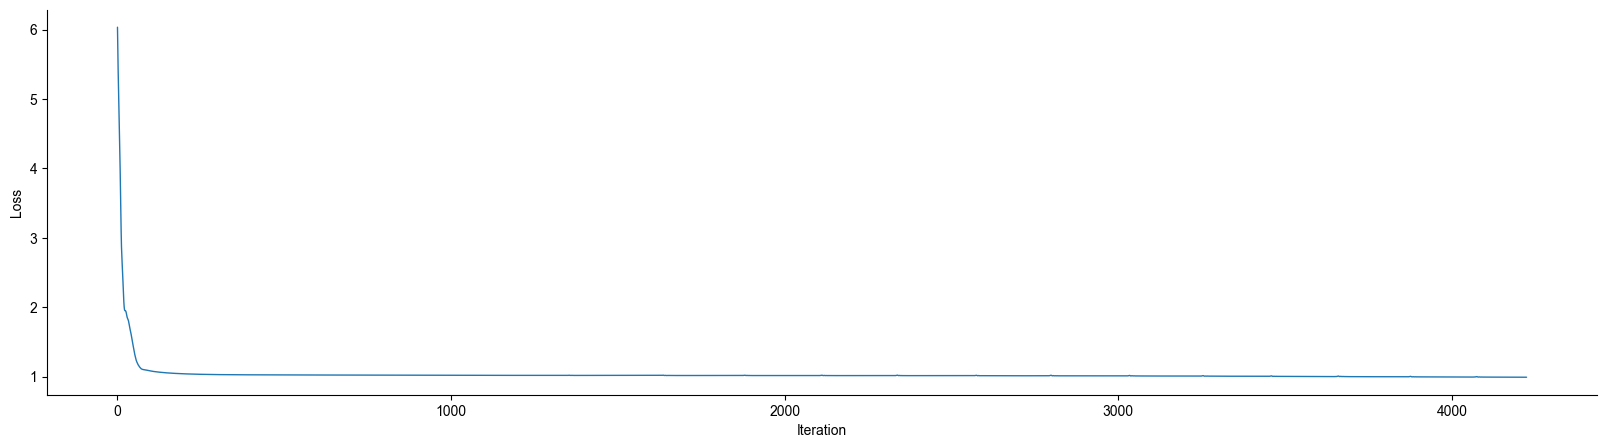

In [8]:
def train():
    t = np.arange(0, 3, 0.3)
    hidden_sizes = np.array([10])
    activation_fns = [sigmoid] * (len(hidden_sizes)) + [lambda x: x]
    nn_weights_1 = init_weights(1, hidden_sizes, 1)
    nn_weights_2 = init_weights(1, hidden_sizes, 1)
    adam(
        t,
        [nn_weights_1, nn_weights_2],
        activation_fns
        trial_solution,
        derivative,
        num_iters=50000,
        step_size=0.01,
        threshold=0.99,
    )

    return [nn1, nn2]


nns = train()

### Evaluating Results

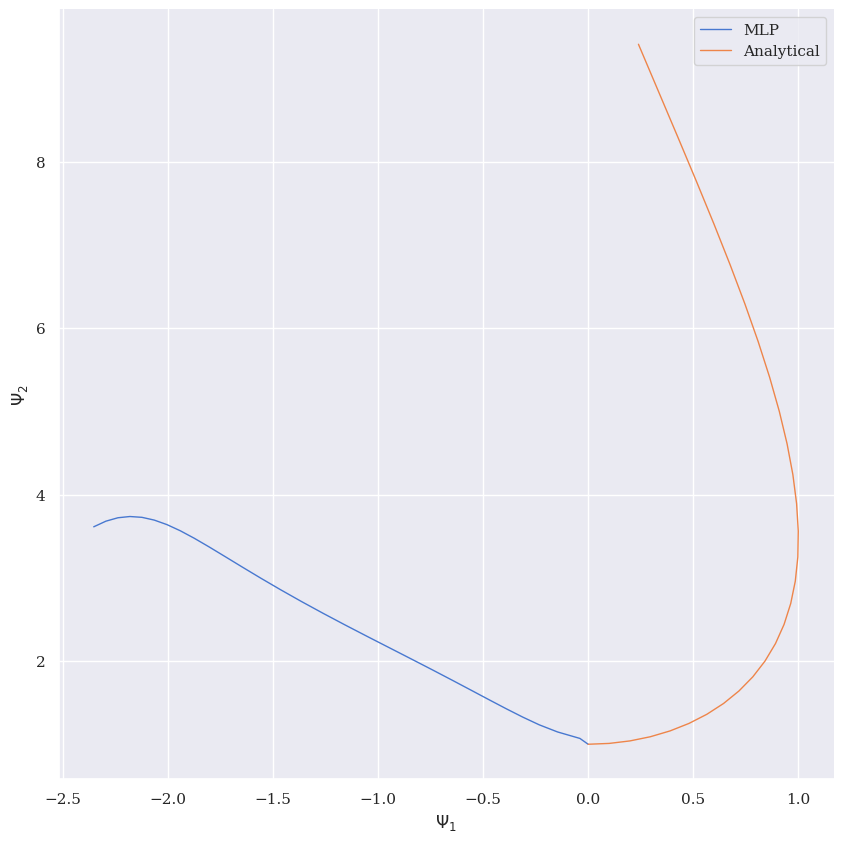

In [9]:
plot_system_ode(
    nns,
    trial_solution,
    analytical_solution,
    t=np.arange(0, 3, 0.1),
)

In [10]:
res = np.array(
    [
        trial_solution(np.arange(0, 5, 0.1), nns[i], nns[i].weights, i)
        for i in range(len(nns))
    ]
)

an_sol = analytical_solution(t)

print_error(res, an_sol)

NameError: name 't' is not defined